In [2]:
pip install causalml

     |████████████████████████████████| 406 kB 3.7 MB/s 
     |████████████████████████████████| 564 kB 47.3 MB/s 
     |████████████████████████████████| 1.8 MB 40.3 MB/s 
     |████████████████████████████████| 718 kB 51.2 MB/s 
  Created wheel for causalml: filename=causalml-0.12.3-cp37-cp37m-linux_x86_64.whl size=1050932 sha256=67a77f6ff4e1f5b50c27167c2fdd992643fe7660971a82060f3099aa18e3dc00
  Stored in directory: /root/.cache/pip/wheels/d7/5e/47/4e965cf8e87c6c10cd7361d910acccd08a1de459f25d55fd23
Successfully built causalml


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier
import warnings

# from causalml.inference.meta import XGBTLearner, MLPTLearner
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.meta import LRSRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# imports from package
import logging
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from copy import deepcopy

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10, p=5, sigma=1.0)

treatment = np.array(['treatment_a' if val==1 else 'control' for val in treatment])

In [ ]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False, bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.0054
INFO:causalml:    RMSE (Treatment):     0.0111
INFO:causalml:   sMAPE   (Control):     0.0051
INFO:causalml:   sMAPE (Treatment):     0.0023
INFO:causalml:    Gini   (Control):     1.0000
INFO:causalml:    Gini (Treatment):     1.0000


[12:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a


[12:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:causalml:    RMSE   (Control):     0.0054
INFO:causalml:    RMSE (Treatment):     0.0111
INFO:causalml:   sMAPE   (Control):     0.0051
INFO:causalml:   sMAPE (Treatment):     0.0023
INFO:causalml:    Gini   (Control):     1.0000
INFO:causalml:    Gini (Treatment):     1.0000


In [ ]:
cate_s

array([[0.        ],
       [0.        ],
       [0.08728257],
       [0.08728278],
       [0.2788527 ],
       [0.05570221],
       [0.        ],
       [0.        ],
       [0.33455563],
       [0.08728248]])

In [ ]:
#以下サンプルコードの実行
#https://gist.github.com/kiwamizamurai/0f59761ae89c1025d8a5c24ae3afe2c6#file-uplift-modeling-tutorial-ipynb

このデータには、直近12ヶ月以内に商品を購入したことがある顧客をランダムに3分割し、

男性向けのメールを送る
女性向けのメールを送る
何もしない
という施策をおこなったときに、顧客が次の2週間以内に

Webサイトを訪問したか
商品を購入したか
商品を購入した人は何ドルいくら使ったのか
などの情報が記録されている。

ここでは、Webサイトへの再訪をコンバージョン（以下CV）として、 男性向けのメールを送るべきなのか女性向けのメールを送るべきなのかをUplift Modelingにより推定する。

CV=サイトを訪問した人が、商品を購入したり、資料請求したりすること。 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (18, 9)
plt.rcParams["font.size"] = 25
sns.set()

In [ ]:
csv_file = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
df = pd.read_csv(csv_file)

# メールを送らなかった人たちのデータを削除
df = df.loc[df["segment"] != "No E-Mail"].reset_index(drop=True)

# カテゴリカル変数をダミー化
categorical_columns = ["zip_code", "channel"]
dummies = pd.get_dummies(df[categorical_columns], drop_first=True)
df = pd.concat([df.drop(categorical_columns, axis=1), dummies], axis=1)

# 説明変数を分けておく
Columns = df.drop(["segment", "visit", "conversion", "spend", "history_segment"], axis=1).columns
X = df.drop(["segment", "visit", "conversion", "spend", "history_segment"], axis=1).values

# 男性向けメールをtreatment, 女性向けメールをcontrolとする
# 男性向けと女性向けの比較を実施する
treatment_label = np.array(df.segment == "Mens E-Mail").astype(int)
visit_label = np.array(df.visit == 1).astype(int) #訪問の有無=yとする

# train, test半分ずつに分ける
X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(X, treatment_label, visit_label, test_size=0.5, random_state=0)

In [ ]:
# (介入を受ける場合のサイト訪問確率)
model_treat = LogisticRegression(C=0.01)
model_treat.fit(X_train[t_train == 1], y_train[t_train == 1])

# (介入を受けない場合のサイト訪問確率)
model_control = LogisticRegression(C=0.01)
model_control.fit(X_train[t_train == 0], y_train[t_train == 0])

LogisticRegression(C=0.01)

In [ ]:
#結果確認
print('###########      treatment')

for feature, coef in zip(Columns, model_treat.coef_[0]):
    print(f"{feature} / {round(coef, 4)}")

print('\n')
print('###########      control')

for feature, coef in zip(Columns, model_control.coef_[0]):
    print(f"{feature} / {round(coef, 4)}")

###########      treatment
recency / -0.0537
history / 0.0006
mens / 0.3589
womens / 0.3003
newbie / -0.4005
zip_code_Surburban / -0.1258
zip_code_Urban / -0.0839
channel_Phone / -0.0754
channel_Web / 0.108


###########      control
recency / -0.0352
history / 0.0005
mens / 0.055
womens / 0.5217
newbie / -0.3542
zip_code_Surburban / -0.2148
zip_code_Urban / -0.182
channel_Phone / -0.1721
channel_Web / 0.0196


Treat: ROC AUC=0.610
Control: ROC AUC=0.609


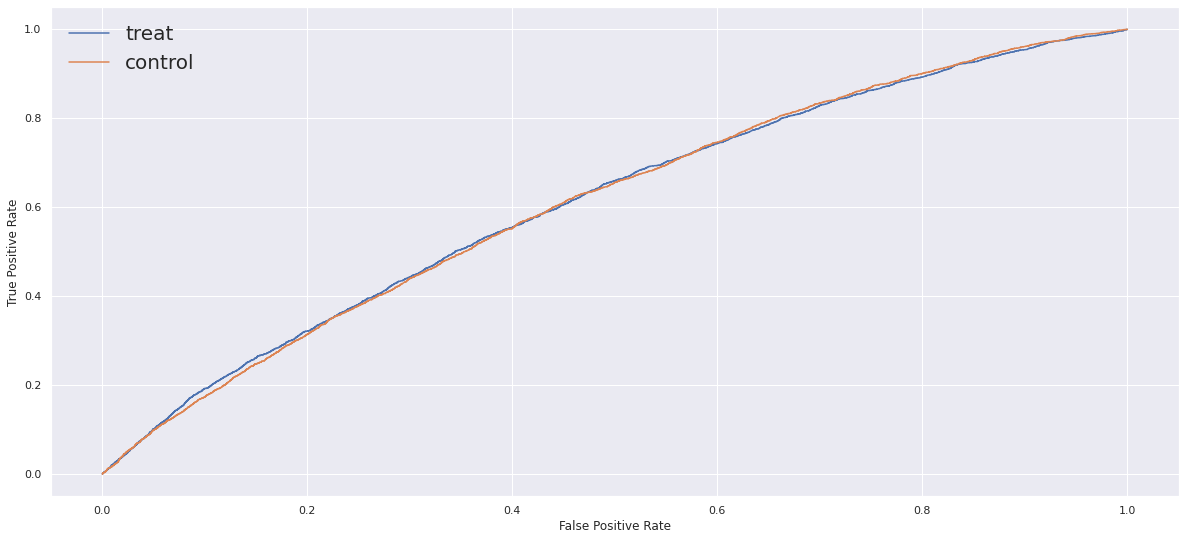

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

treat_auc = roc_auc_score(y_test, model_treat.predict_proba(X_test)[:, 1])
control_auc = roc_auc_score(y_test, model_control.predict_proba(X_test)[:, 1])

# summarize scores
print('Treat: ROC AUC=%.3f' % (treat_auc))
print('Control: ROC AUC=%.3f' % (control_auc))

# calculate roc curves
t_fpr, t_tpr, t_thresholds = roc_curve(y_test, model_treat.predict_proba(X_test)[:, 1])
c_fpr, c_tpr, c_thresholds = roc_curve(y_test, model_control.predict_proba(X_test)[:, 1])

# plot the roc curve for the model
plt.plot(t_fpr, t_tpr, label='treat')
plt.plot(c_fpr, c_tpr, label='control')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

In [ ]:
print('treat accuracy: ', sum(model_treat.predict(X_test)==y_test)/len(y_test))
print('control accuracy: ', sum(model_control.predict(X_test)==y_test)/len(y_test))

treat accuracy:  0.8346371855530051
control accuracy:  0.8346840305429334


In [ ]:
# (介入を受ける場合のサイト訪問確率) - (介入を受けない場合のサイト訪問確率) をuplift_scoreとして算出
proba_treat, proba_control = model_treat.predict_proba(X_test)[:, np.where(model_treat.classes_ == 1)].flatten(), model_control.predict_proba(X_test)[:, np.where(model_control.classes_ == 1)].flatten()
uplift_score = proba_treat - proba_control

df_result = pd.DataFrame({'y_test': y_test,
                          't_test': t_test,
                          'uplift': uplift_score}).sort_values(by=['uplift'], ascending=False)
                          
df_result.T

,16865,5011,5442,6027,19889,2599,4343,16940,16089,5099,...,14949,19710,3981,13709,20252,17995,1228,17073,6589,8756
y_test,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
t_test,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000
uplift,0.1632,0.1603,0.1470,0.1438,0.1405,0.1379,0.1352,0.1346,0.1328,0.1305,...,-0.0406,-0.0413,-0.0413,-0.0414,-0.0415,-0.0421,-0.0422,-0.0422,-0.0424,-0.0425


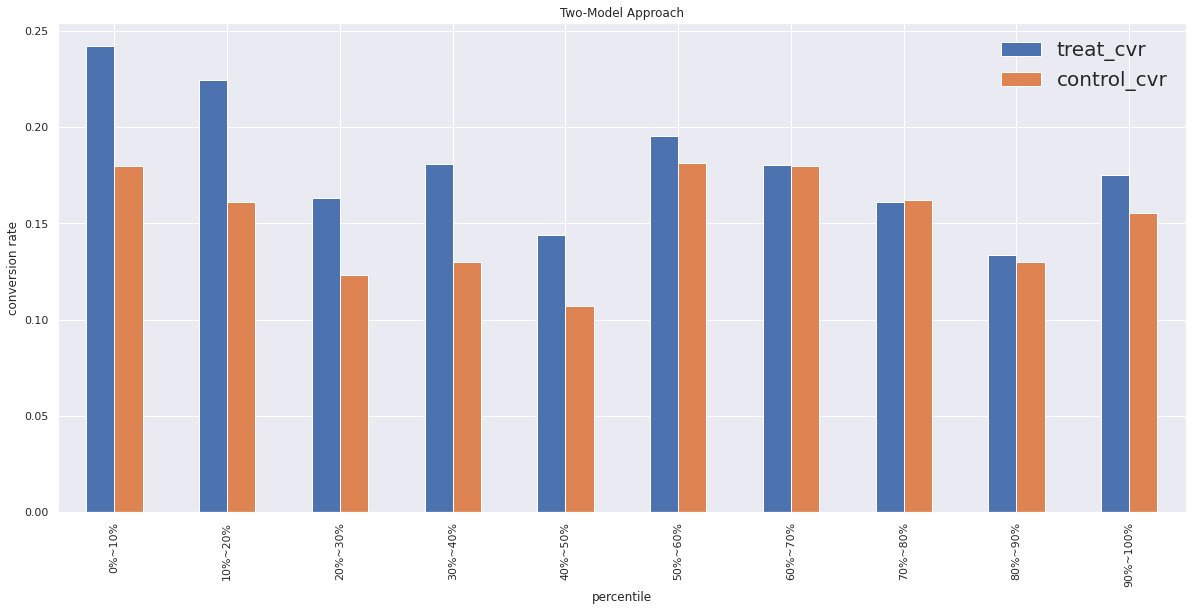

In [ ]:
result = list(zip(y_test, t_test, uplift_score))
result.sort(key=lambda row: row[2], reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))
for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]

    # count number of users in treatment group and control group
    treat_uu = list( map(lambda item: item[1], quantiled_result) ).count(True)
    control_uu = list( map(lambda item: item[1], quantiled_result) ).count(False)

    # count number of cv in treatment group and control group
    treat_cv = [item[0] for item in quantiled_result if bool(item[1]) is True].count(True)
    control_cv = [item[0] for item in quantiled_result if bool(item[1]) is False].count(True)

    # calculate cvr of treatment group and control group
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    label = '{}%~{}%'.format(n * 10, (n + 1) * 10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel('percentile')
plt.ylabel('conversion rate')

plt.title('Two-Model Approach')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})


#図から、スコアの上位60%は介入をおこなう（男性向けメールを送付する）ほうが反応率が高くなり、
#スコアの下位40%は介入をおこなわない（女性向けメールを送付する）ほうが反応率が高くなることがわかる

In [ ]:
len(result)
#np.random.randint(len(result))

21347

In [ ]:
#Webサイトへの再訪をコンバージョン（以下CV）
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

#   visit, treat, uplift
for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1   #treatでcountup
        if is_cv:
            treat_cv += 1 #treat and visit でcountup
        # positive outcomes of fitst k samples
        treat_cvr = treat_cv / treat_uu   #treat中の訪問率
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        # positive outcomes of fitst k samples
        control_cvr = control_cv / control_uu  #control中の訪問率

    lift = (treat_cvr - control_cvr) * treat_uu  
    stat_data.append([
        is_cv, is_treat, score,
        treat_uu, control_uu, treat_cv, control_cv,
        treat_cvr, control_cvr, lift
    ])

# 統計データを、DataFrameに変換する
columns = [
    'is_cv', 'is_treat', 'score',
    'treat_uu', 'control_uu', 'treat_cv', 'control_cv',
    'treat_cvr', 'control_cvr', 'lift'
]

stat_df = pd.DataFrame(stat_data, columns=columns)

# ベースラインを書き加える
stat_df['baseline'] = stat_df.index * stat_df['lift'][:] / len(stat_df.index)
stat_df.head()

,is_cv,is_treat,score,treat_uu,control_uu,treat_cv,control_cv,treat_cvr,control_cvr,lift,baseline
0,0,0,0.1632,0,1,0,0,0.0000,0.0000,0.0000,0.0000
1,0,0,0.1603,0,2,0,0,0.0000,0.0000,0.0000,0.0000
2,0,0,0.1470,0,3,0,0,0.0000,0.0000,0.0000,0.0000
3,0,0,0.1438,0,4,0,0,0.0000,0.0000,0.0000,0.0000
4,0,1,0.1405,1,4,0,0,0.0000,0.0000,0.0000,0.0000


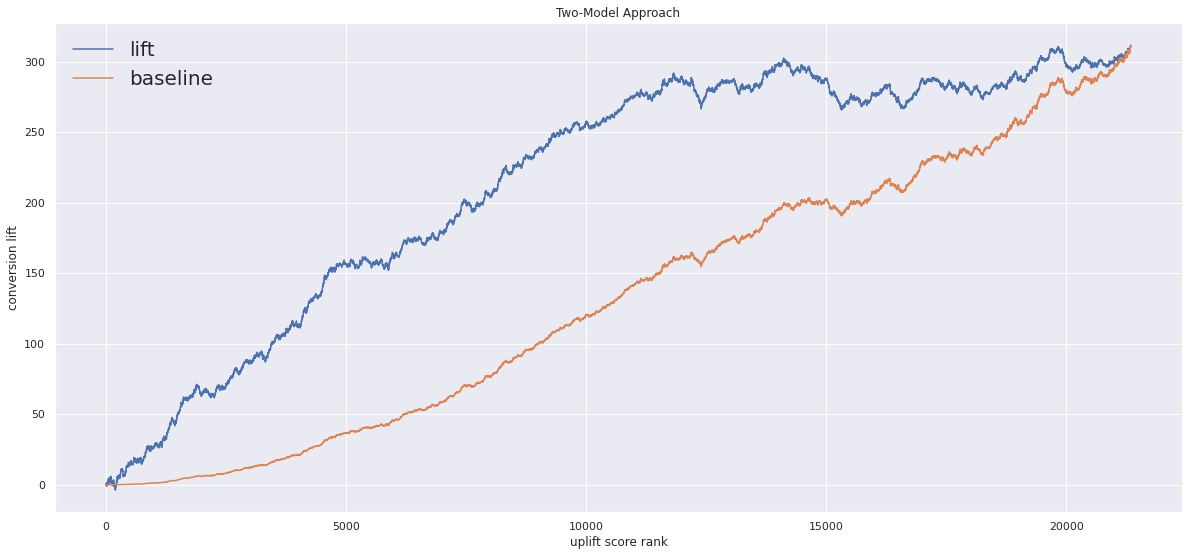

In [ ]:
stat_df.plot(y=['lift', 'baseline'])

plt.xlabel('uplift score rank')
plt.ylabel('conversion lift')
plt.title('Two-Model Approach')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

In [ ]:
stat_df.sort_values(by='score', ascending=False).loc[12200, 'score']

0.013894046518756226

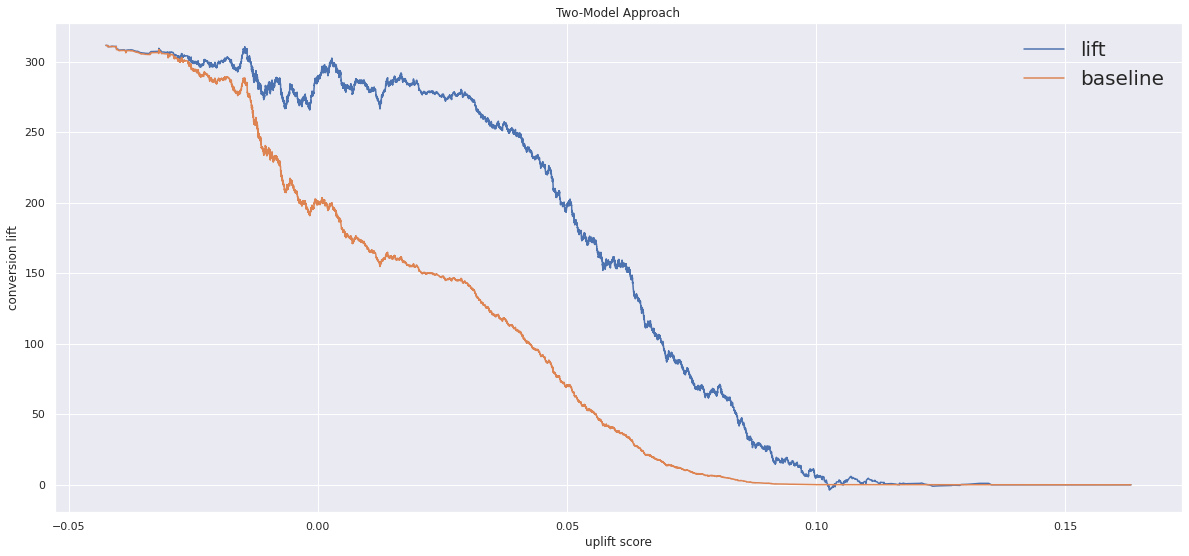

In [ ]:

stat_df.plot(x='score', y=['lift','baseline'])
plt.xlabel('uplift score')
plt.ylabel('conversion lift')
plt.title('Two-Model Approach')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

In [ ]:
AUUC = 0
kizami = 1./len(stat_df)
for i in range(len(stat_df)):
  height = stat_df.lift[i] - stat_df.baseline[i]
  AUUC += kizami * height

print('AUUC ', AUUC) 

AUUC  84.14180863104234


In [ ]:
print('num of treat ', len(df[treatment_label==1]))
print('num of control ', len(df[treatment_label==0]))

num of treat  21307
num of control  21387


Text(0.5, 0, 'score / probability')

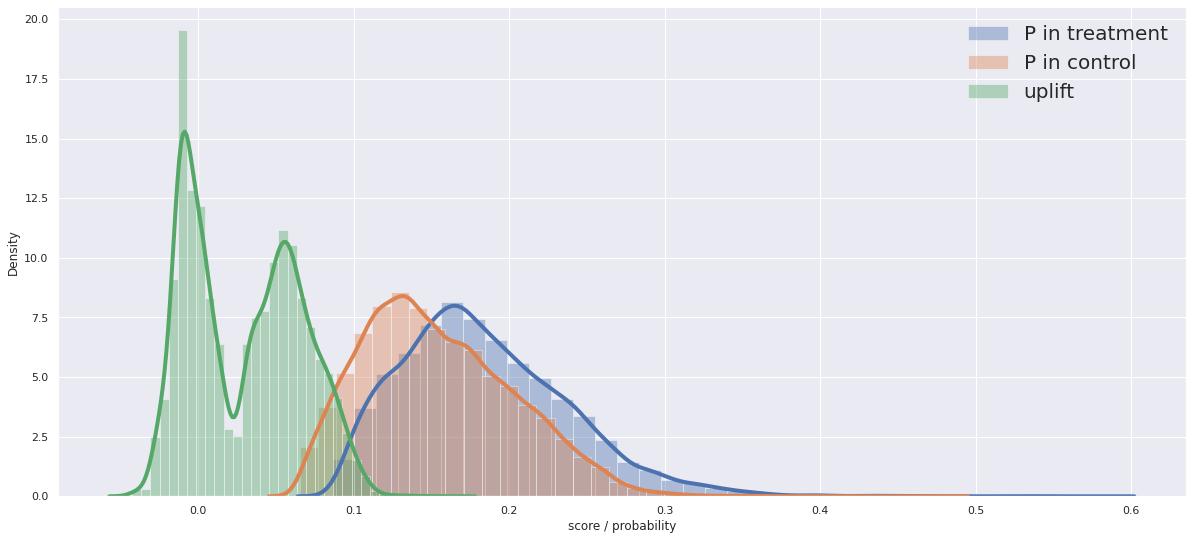

In [ ]:
bins = 35

sns.distplot(proba_treat, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='P in treatment')
sns.distplot(proba_control, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='P in control')
sns.distplot(stat_df.score, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='uplift')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})
plt.xlabel('score / probability')



---
RandomForestベースのUplift-modelingを試してみる
https://dev.classmethod.jp/articles/causalml-randomforest-uplifting-model/


まずはTree-Based Algorithmsを読んで次に「Decision trees for uplift modeling with single and multiple treatments」や「Ensemble methods for uplift modeling」を読んでいくといいかもしれません。

Tree-Based Algorithm
https://causalml.readthedocs.io/en/latest/methodology.html#tree-based-algorithms

Decision trees for uplift modeling with single and multiple treatments
https://link.springer.com/article/10.1007/s10115-011-0434-0

Ensemble methods for uplift modeling
https://link.springer.com/article/10.1007/s10618-014-0383-9

---



In [3]:
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier, uplift_tree_string, uplift_tree_plot
from causalml.metrics import plot_gain


# データの取得
df, x_names = make_uplift_classification()

# 列名を変更
x_names_new = ['feature_%s'%(i) for i in range(len(x_names))]
rename_dict = {x_names[i]:x_names_new[i] for i in range(len(x_names))}
df = df.rename(columns=rename_dict)
x_names = x_names_new

# データの確認
df.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,treatment_group_key,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,conversion,treatment_effect
0,control,-0.542888,1.976361,-0.531359,-2.354211,-0.380629,-2.614321,-0.128893,0.448689,-2.275192,...,-1.315304,0.742654,1.891699,-2.428395,1.541875,-0.817705,-0.610194,-0.591581,0,0
1,treatment3,0.258654,0.552412,1.434239,-1.422311,0.089131,0.790293,1.159513,1.578868,0.166540,...,-1.391878,-0.623243,2.443972,-2.889253,2.018585,-1.109296,-0.380362,-1.667606,0,0
2,treatment1,1.697012,-2.762600,-0.662874,-1.682340,1.217443,0.837982,1.042981,0.177398,-0.112409,...,-1.132497,1.050179,1.573054,-1.788427,1.341609,-0.749227,-2.091521,-0.471386,0,0
3,treatment2,-1.441644,1.823648,0.789423,-0.295398,0.718509,-0.492993,0.947824,-1.307887,0.123340,...,-2.084619,0.058481,1.369439,0.422538,1.087176,-0.966666,-1.785592,-1.268379,1,1
4,control,-0.625074,3.002388,-0.096288,1.938235,3.392424,-0.465860,-0.919897,-1.072592,-1.331181,...,-1.403984,0.760430,1.917635,-2.347675,1.560946,-0.833067,-1.407884,-0.781343,0,0


In [4]:
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)
#今回はこのデータを「何らかの施策を実施した結果のデータ（会員ID単位でデータを保持、とする）」とみなして、
#「次の施策対象者」を選定することを想定したフローを実施してみようと思います。

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.511,1000
treatment1,0.514,1000
treatment2,0.559,1000
treatment3,0.600,1000
All,0.546,4000


In [5]:
# データの分割
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

# 必要列のみに絞り込み
x_names = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18']


#REF. https://github.com/uber/causalml/blob/master/examples/uplift_tree_visualization.ipynb

# 学習
uplift_model = UpliftRandomForestClassifier(n_estimators=500, 
                                            max_depth = 5, 
                                            min_samples_leaf = 50, 
                                            min_samples_treatment = 20, 
                                            evaluationFunction='ED', # Choose from one of the models: 'KL', 'ED', 'Chi', 'CTS'.
                                            control_name='control'
                                           )
uplift_model.fit(X=df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

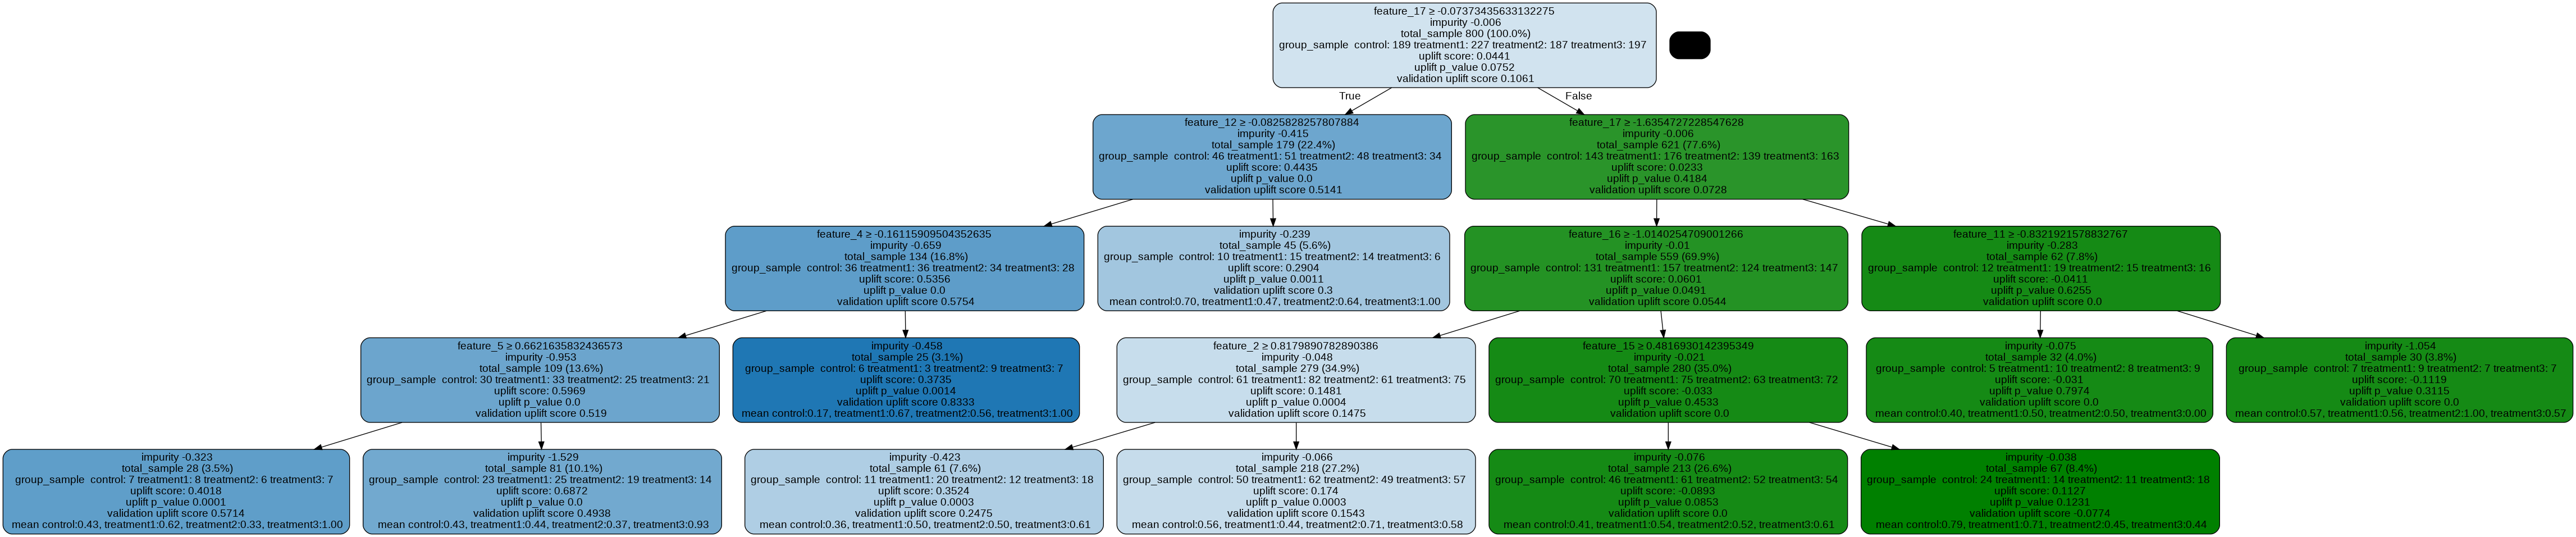

In [6]:
# RFの中の木のうちの一つについて、中身を表示する
uplift_tree = uplift_model.uplift_forest[0]
uplift_tree.fill(X=df_test[x_names].values, 
                 treatment=df_test['treatment_group_key'].values, 
                 y=df_test['conversion'].values)

# Plot
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())

In [19]:
# 推論 
pred_test = uplift_model.predict(X=df_test[x_names].values,
                                 full_output=False)
# どの列がどの介入群かわかるようにする
#pred_test = pd.DataFrame(pred_test,columns=uplift_model.classes_)
pred_test = pd.DataFrame(pred_test)
pred_test.rename(columns={0: 'treatment1',1: 'treatment2',2: 'treatment3'},inplace=True)
# 確認
print(pred_test.head())
print('='*40)
print(pred_test.describe())

#下記のように、複数の介入群それぞれ別々にITEの推論値が取得できます。
#ITE(Individual Treatment Effects)

   treatment1  treatment2  treatment3
0    0.017053    0.071274    0.011399
1    0.017356    0.109550    0.043510
2    0.009342    0.038178   -0.005149
3    0.067913    0.075200    0.511737
4    0.093313    0.087875    0.372668
       treatment1  treatment2  treatment3
count  800.000000  800.000000  800.000000
mean     0.009234    0.049571    0.100944
std      0.076116    0.058942    0.195641
min     -0.206669   -0.129142   -0.139222
25%     -0.036181    0.013966   -0.022138
50%      0.012813    0.050344    0.008750
75%      0.047991    0.082243    0.156622
max      0.247857    0.251464    0.667030


In [20]:
# どの介入群に割り当てても負の効果しかもたらさない場合は「Control」とするために列を追加
# すべて負の場合、Controlが採用される
pred_test = pred_test.assign(Control=0.0)

max_treatment_key = pd.DataFrame(pred_test.idxmax(axis=1))
max_treatment_key.rename(columns={0:'max_treatment_key'}, inplace=True)
max_treatment_value = pd.DataFrame(pred_test.max(axis=1))
max_treatment_value.rename(columns={0:'max_treatment_value'}, inplace=True)

# ベストtreatment とITE値
max_treatment = pd.concat([max_treatment_key, max_treatment_value], axis=1)

# 元のDFと上記までの計算結果を結合
result_test = pd.concat([df_test, pred_test, max_treatment], axis=1)
# 必要列だけに絞り込み
result_test = result_test.loc[:,['treatment_group_key','conversion', 
                                 'treatment1', 'treatment2', 'treatment3', 
                                 'max_treatment_key', 'max_treatment_value']]
# 結果の確認
result_test.head(10)

,treatment_group_key,conversion,treatment1,treatment2,treatment3,max_treatment_key,max_treatment_value
0,treatment3,0,0.017053,0.071274,0.011399,treatment2,0.071274
1,treatment1,0,0.017356,0.109550,0.043510,treatment2,0.109550
2,treatment1,1,0.009342,0.038178,-0.005149,treatment2,0.038178
3,control,0,0.067913,0.075200,0.511737,treatment3,0.511737
4,control,1,0.093313,0.087875,0.372668,treatment3,0.372668
5,treatment2,1,-0.006504,0.028485,0.220045,treatment3,0.220045
6,treatment1,0,-0.085010,-0.035676,-0.065228,Control,0.000000
7,treatment1,1,0.046941,0.076035,0.150373,treatment3,0.150373
8,control,1,0.024161,0.063065,-0.010520,treatment2,0.063065
9,treatment1,0,-0.104174,-0.006419,-0.031195,Control,0.000000


In [23]:
from causalml.metrics import plot,auuc_score

# 介入したか否か、を列として追加
result_test['treatment_flg'] = 1
# controlには0を設定
result_test.loc[(result_test['treatment_group_key'] == 'control'), 'treatment_flg'] = 0


# 可視化  Plot one of the lift/gain/Qini charts of model estimates.
plot(df=result_test.loc[:,['conversion','treatment_flg', 'max_treatment_value']], 
     outcome_col='conversion', 
     treatment_col='treatment_flg'
   )

,treatment_group_key,conversion,treatment1,treatment2,treatment3,max_treatment_key,max_treatment_value,treatment_flg
0,treatment3,0,0.017053,0.071274,0.011399,treatment2,0.071274,1
1,treatment1,0,0.017356,0.109550,0.043510,treatment2,0.109550,1
2,treatment1,1,0.009342,0.038178,-0.005149,treatment2,0.038178,1
3,control,0,0.067913,0.075200,0.511737,treatment3,0.511737,0
4,control,1,0.093313,0.087875,0.372668,treatment3,0.372668,0


In [24]:
#上記の結果から、施策対象者を選定するための閾値を決めたら、下記のように値を抽出して、
#(今回は、上位300人目のScoreを閾値としました)
#今回作成したモデルで推論して、この閾値より大きい対象者を施策対象者にする、というような使い方ができそうです。
#(この時、どの介入群に割り当てるか、も推論できる)

result_test.max_treatment_value.sort_values(ascending=False)[300]

0.39062966667996346

In [26]:
#また、定量評価指標として、AUUC（Area Under the Uplift Curve）も簡単に計算できます。
#(今回は複数のTreatment群の中のMAX値を使っている点に注意してください)

# AUUCの確認
auuc_score(df=result_test.loc[:,['conversion','treatment_flg', 'max_treatment_value']], 
          outcome_col='conversion', 
          treatment_col='treatment_flg')

max_treatment_value    0.901182
Random                 0.446675
dtype: float64